## Task 1

In [ ]:
!pip install datasets tensorflow scikit-learn augly -q

In [ ]:
from PIL import Image
import datasets

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

from tqdm.notebook import tqdm
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import augly.image as imaugs

We have downloaded the cats and dogs dataset from the following link: https://www.kaggle.com/datasets/samuelcortinhas/cats-and-dogs-image-classification?select=test

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
BASE_DIR = r"/content/drive/MyDrive/stt-05"

In [ ]:
examples = os.listdir(BASE_DIR)
examples

['dogs', 'cats']

In [ ]:
for dir in examples:
    print(f"Number of {dir[:-1]} images: {len(os.listdir(os.path.join(BASE_DIR, dir)))}")

Number of dog images: 70
Number of cat images: 70


As we can see the number of cat and dog images are equal so we would be fine if we simply split these sets into 80:20 and move the images to different folders.

In [ ]:
cat_images = os.listdir(os.path.join(BASE_DIR, "cats"))
dog_images = os.listdir(os.path.join(BASE_DIR, "dogs"))

In [ ]:
# Shuffle the list of image filenames to ensure a random split
random.shuffle(cat_images)
random.shuffle(dog_images)

In [ ]:
# Split dataset into 80% training and 20% testing
cat_train = cat_images[:int(len(cat_images) * 0.8)]
cat_test = cat_images[int(len(cat_images) * 0.8):]

dog_train = dog_images[:int(len(dog_images) * 0.8)]
dog_test = dog_images[int(len(dog_images) * 0.8):]

In [ ]:
# Print dataset distribution
print(f"Number of training cat images: {len(cat_train)}")
print(f"Number of testing cat images: {len(cat_test)}")

print(f"Number of training dog images: {len(dog_train)}")
print(f"Number of testing dog images: {len(dog_test)}")

Number of training cat images: 56
Number of testing cat images: 14
Number of training dog images: 56
Number of testing dog images: 14


In [ ]:
# Here, we are moving the images to the respective directories
TRAIN_DIR = os.path.join(BASE_DIR, "train")
TEST_DIR = os.path.join(BASE_DIR, "test")

os.makedirs(TRAIN_DIR, exist_ok = True)
os.makedirs(TEST_DIR, exist_ok = True)

for img in cat_train:
    os.rename(os.path.join(BASE_DIR, "cats", img), os.path.join(TRAIN_DIR, img))

for img in cat_test:
    os.rename(os.path.join(BASE_DIR, "cats", img), os.path.join(TEST_DIR, img))

for img in dog_train:
    os.rename(os.path.join(BASE_DIR, "dogs", img), os.path.join(TRAIN_DIR, img))

for img in dog_test:
    os.rename(os.path.join(BASE_DIR, "dogs", img), os.path.join(TEST_DIR, img))

## Function for augmentation

In [ ]:
import augly.image as imaugs

In [ ]:
def random_augmentations(img):
    """
    Samples a set of 3 augmentations from a list of 10 augmentation functions and applies them sequentially to the input image.
    """

    # Define a list of possible augmentation functions with random parameters
    aug_funcs = [
        lambda x: imaugs.rotate(x, degrees = random.uniform(-10, 10)),
        lambda x: imaugs.scale(x, factor = random.uniform(0.5, 1.5)),
        lambda x: imaugs.blur(x, radius = random.uniform(1, 3)),
        lambda x: imaugs.hflip(x),
        lambda x: imaugs.vflip(x),
        lambda x: imaugs.color_jitter(x, brightness_factor = random.uniform(0.5, 1.5), contrast_factor = random.uniform(0.5, 1.5), saturation_factor = random.uniform(0.5, 1.5)),
        lambda x: imaugs.resize(x, width = 224, height = 224),
        lambda x: imaugs.grayscale(x),
        lambda x: imaugs.brightness(x, factor = random.uniform(0.5, 1.5)),
        lambda x: imaugs.color_jitter(brightness_factor = random.uniform(0.5, 1.5), contrast_factor = random.uniform(0.5, 1.5))
    ]

    # Randomly sample 3 augmentation lambda functions
    aug_sequence = random.sample(aug_funcs, 3)

    # Apply the selected augmentations sequentially
    augmented_img = img
    for aug in aug_sequence:
        augmented_img = aug(augmented_img)

    return augmented_img

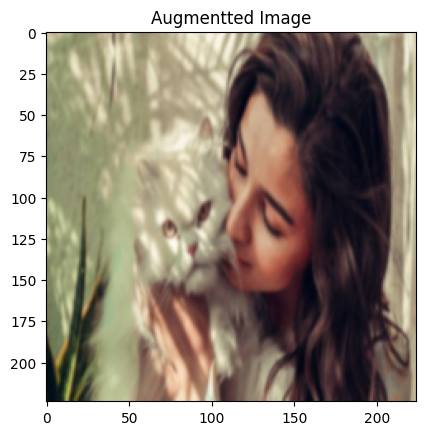

In [ ]:
# Example of augmentation function implemented above
file_path = os.path.join(TRAIN_DIR, os.listdir(TRAIN_DIR)[0])
img = Image.open(file_path).convert("RGB")

plt.title("Augmentted Image")
plt.imshow(random_augmentations(img))

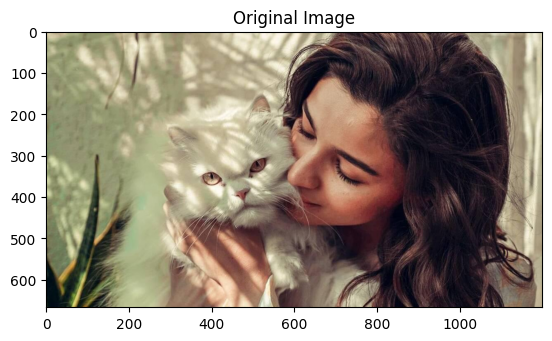

In [ ]:
plt.title("Original Image")
plt.imshow(Image.open(file_path).convert("RGB"))

## Augmenting the entire training data

In [ ]:
AUG_DIR = os.path.join(BASE_DIR, "augmented")
os.makedirs(AUG_DIR, exist_ok = True)

In [ ]:
for i in range(2):
    for images in os.listdir(TRAIN_DIR):
        img = Image.open(os.path.join(TRAIN_DIR, images)).convert("RGB")
        img = random_augmentations(img)
        img.save(os.path.join(AUG_DIR, images)[:-4] +  "_" + str(i), format = "PNG")

## Stats of the augmented data

In [ ]:
total_train_images = len(os.listdir(TRAIN_DIR)) + len(os.listdir(AUG_DIR))
total_test_images = len(os.listdir(TEST_DIR))

print(f"Total number of training images before augmentation: {len(os.listdir(TRAIN_DIR))}")
print(f"Total number of training images after augmentation: {total_train_images}")
print(f"Total number of testing images: {total_test_images}")

Total number of training images before augmentation: 112
Total number of training images after augmentation: 336
Total number of testing images: 28


In [ ]:
AUG_DIR = aug_dir
total_train_images = len(os.listdir(TRAIN_DIR)) + len(os.listdir(AUG_DIR))
total_test_images = len(os.listdir(TEST_DIR))

train_cat_images = train_dog_images = 0
for images in os.listdir(TRAIN_DIR):
    if "cat" in images:
        train_cat_images += 1
    elif "dog" in images:
        train_dog_images += 1

train_cat_before = train_cat_images
train_dog_before = train_dog_images
train_before = train_cat_before + train_dog_before

for images in os.listdir(AUG_DIR):
    if "cat" in images:
        train_cat_images += 1
    elif "dog" in images:
        train_dog_images += 1

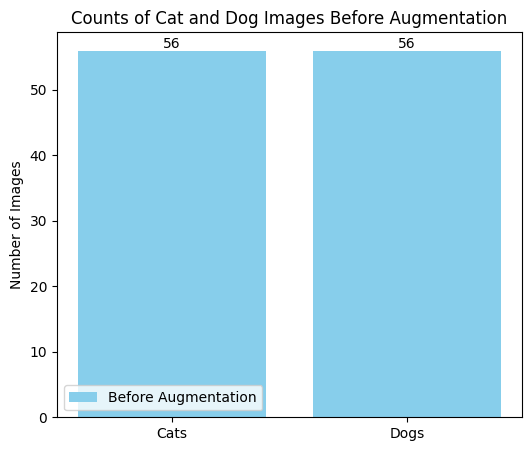

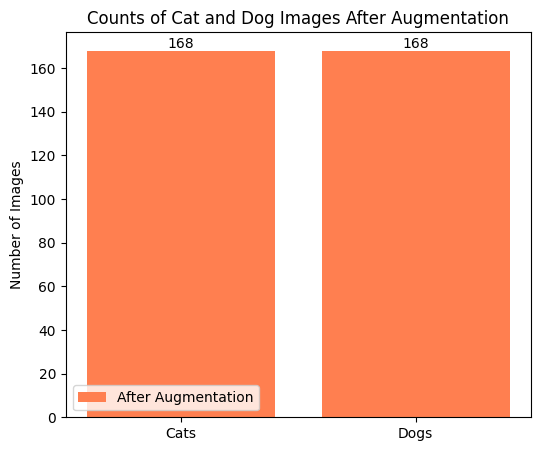

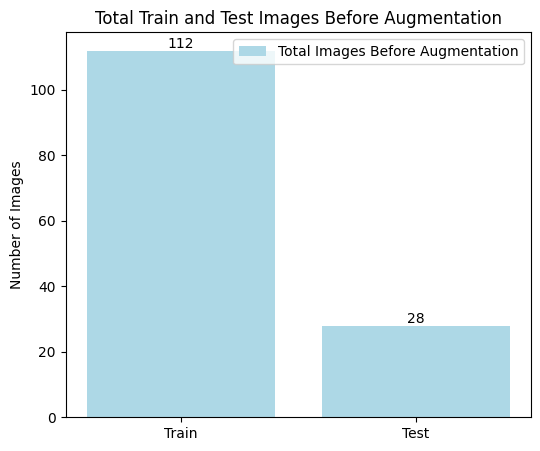

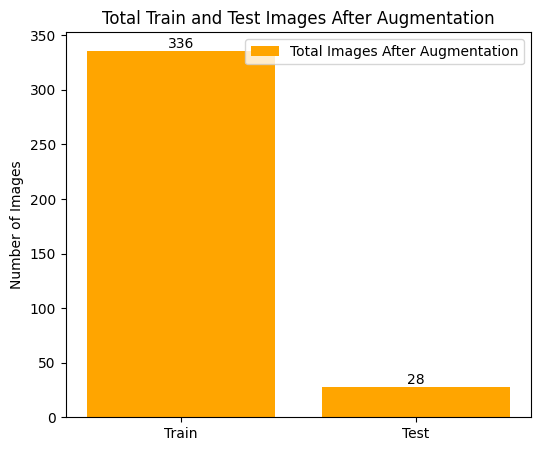

In [ ]:
labels = ["Cats", "Dogs"]

train_before_values = [train_cat_before, train_dog_before]
train_after_values = [train_cat_images, train_dog_images]

total_train_before = train_cat_before + train_dog_before
total_train_after = train_cat_images + train_dog_images
total_test = total_test_images

# Plot for Cat & Dog Count Before Augmentation
fig, ax = plt.subplots(figsize=(6, 5))
rects1 = ax.bar(labels, train_before_values, color = 'skyblue', label = 'Before Augmentation')

ax.set_ylabel('Number of Images')
ax.set_title('Counts of Cat and Dog Images Before Augmentation')
ax.legend()

for rect in rects1:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f'{rect.get_height()}', ha = 'center', va = 'bottom')

plt.show()

# Plot for Cat & Dog Count After Augmentation
fig, ax = plt.subplots(figsize = (6, 5))
rects2 = ax.bar(labels, train_after_values, color='coral', label='After Augmentation')

ax.set_ylabel('Number of Images')
ax.set_title('Counts of Cat and Dog Images After Augmentation')
ax.legend()

for rect in rects2:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f'{rect.get_height()}',ha = 'center', va = 'bottom')

plt.show()

# Plot for Total Train & Test Images Before Augmentation
fig, ax = plt.subplots(figsize = (6, 5))
rects3 = ax.bar(["Train", "Test"], [total_train_before, total_test], color = 'lightblue', label = 'Total Images Before Augmentation')

ax.set_ylabel('Number of Images')
ax.set_title('Total Train and Test Images Before Augmentation')
ax.legend()

for rect in rects3:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f'{rect.get_height()}', ha = 'center', va = 'bottom')
plt.show()

# Plot for Total Train & Test Images After Augmentation
fig, ax = plt.subplots(figsize=(6, 5))
rects4 = ax.bar(["Train", "Test"], [total_train_after, total_test], color='orange', label='Total Images After Augmentation')

ax.set_ylabel('Number of Images')
ax.set_title('Total Train and Test Images After Augmentation')
ax.legend()

for rect in rects4:
    ax.text(rect.get_x() + rect.get_width()/2, rect.get_height(), f'{rect.get_height()}', ha = 'center', va = 'bottom')
plt.show()